Beaming and Boosting
============================

Due to concerns about accuracy, support for Beaming & Boosting has been disabled in the 2.2 release of PHOEBE.

It may come as surprise that support for Doppler boosting has been dropped in PHOEBE 2.2. This document details the underlying causes for that decision and explains the conditions that need to be met for boosting to be re-incorporated into PHOEBE.

Let's start by reviewing the theory behind Doppler boosting. The motion of the stars towards or away from the observer changes the amount of received flux due to three effects:

* the spectrum is Doppler-shifted, so the flux, being the passband-weighted integral of the spectrum, changes;
* the photons' arrival rate changes due to time dilation; and
* radiation is beamed in the direction of motion due to light aberration.

It turns out that the combined boosting signal can be written as:

$$ I_\lambda = I_{\lambda,0} \left( 1 - B(\lambda) \frac{v_r}c \right), $$

where $I_{\lambda,0}$ is the intrinsic (rest-frame) passband intensity, $I_\lambda$ is the boosted passband intensity, $v_r$ is radial velocity, $c$ is the speed of light and $B(\lambda)$ is the boosting index:

$$ B(\lambda) = 5 + \frac{\mathrm{d}\,\mathrm{ln}\, I_\lambda}{\mathrm{d}\,\mathrm{ln}\, \lambda}. $$

The term $\mathrm{d}(\mathrm{ln}\, I_\lambda) / \mathrm{d}(\mathrm{ln}\, \lambda)$ is called spectral index. As $I_\lambda$ depends on $\lambda$, we average it across the passband:

$$ B_\mathrm{pb} = \frac{\int_\lambda \mathcal{P}(\lambda) \mathcal S(\lambda) B(\lambda) \mathrm d\lambda}{\int_\lambda \mathcal{P}(\lambda) \mathcal S(\lambda) \mathrm d\lambda}. $$

In what follows we will code up these steps and demonstrate the inherent difficulty of realizing a robust, reliable treatment of boosting.

Import all python modules that we'll need:

In [63]:
import phoebe
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

Pull a set of Sun-like emergent intensities as a function of $\mu = \cos \theta$ from the Castelli and Kurucz database of model atmospheres (the necessary file can be [downloaded from here](http://phoebe-project.org/static/T06000G40P00.fits)):

In [6]:
wl = np.arange(900., 39999.501, 0.5)/1e10
with fits.open('T06000G40P00.fits') as hdu:
    Imu = 1e7*hdu[0].data

Grab only the normal component for testing purposes:

In [10]:
Inorm = Imu[-1,:]

Now let's load a Johnson V passband and the transmission function $P(\lambda)$ contained within:

In [14]:
pb = phoebe.get_passband('Johnson:V')

Tesselate the wavelength interval to the range covered by the passband:

In [17]:
keep = (wl >= pb.ptf_table['wl'][0]) & (wl <= pb.ptf_table['wl'][-1])
Inorm = Inorm[keep]
wl = wl[keep]

Calculate $S(\lambda) P(\lambda)$ and plot it, to make sure everything so far makes sense:

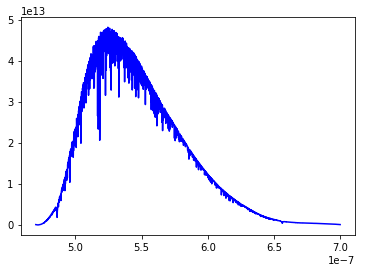

In [21]:
plt.plot(wl, Inorm*pb.ptf(wl), 'b-')
plt.show()

Now let's compute the term $\mathrm{d}(\mathrm{ln}\, I_\lambda) / \mathrm{d}(\mathrm{ln}\, \lambda)$. First we will compute $\mathrm{ln}\,\lambda$ and $\mathrm{ln}\,I_\lambda$ and plot them:

In [22]:
lnwl = np.log(wl)
lnI = np.log(Inorm)

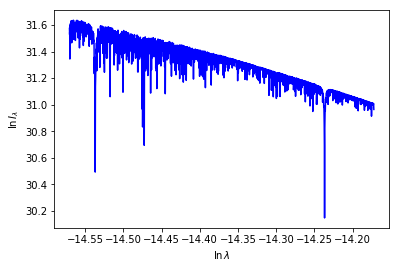

In [24]:
plt.xlabel(r'$\mathrm{ln}\,\lambda$')
plt.ylabel(r'$\mathrm{ln}\,I_\lambda$')
plt.plot(lnwl, lnI, 'b-')
plt.show()

Per equation above, $B(\lambda)$ is then the slope of this curve (plus 5). Herein lies the problem: what part of this graph do we fit a line to? In versions 2 and 2.1, PHOEBE used a 5th order Legendre polynomial to fit the spectrum and then sigma-clipping to get to the continuum. Finally, it computed an average derivative of that Legendrian and proclaimed that $B(\lambda)$. The order of the Legendre polynomial and the values of sigma for sigma-clipping have been set ad-hoc and kept fixed for every single spectrum.

In [69]:
envelope = np.polynomial.legendre.legfit(lnwl, lnI, 5)
continuum = np.polynomial.legendre.legval(lnwl, envelope)
diff = lnI-continuum
sigma = np.std(diff)
clipped = (diff > -sigma)
while True:
    Npts = clipped.sum()
    envelope = np.polynomial.legendre.legfit(lnwl[clipped], lnI[clipped], 5)
    continuum = np.polynomial.legendre.legval(lnwl, envelope)
    diff = lnI-continuum
    clipped = clipped & (diff > -sigma)
    if clipped.sum() == Npts:
        break

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RankWarning: The fit may be poorly conditioned
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: RankWarning: The fit may be poorly conditioned
  


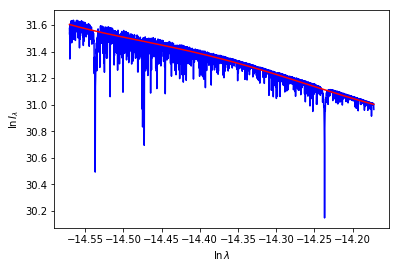

In [70]:
plt.xlabel(r'$\mathrm{ln}\,\lambda$')
plt.ylabel(r'$\mathrm{ln}\,I_\lambda$')
plt.plot(lnwl, lnI, 'b-')
plt.plot(lnwl, continuum, 'r-')
plt.show()

It is clear that there is a pretty strong systematics here that we sweep under the rug. Thus, we need to revise the way we compute the spectral index and make it robust before we claim that we support boosting.

For fun, this is what would happen if we tried to estimate $B(\lambda)$ at each $\lambda$:

In [72]:
dlnwl = lnwl[1:]-lnwl[:-1]
dlnI = lnI[1:]-lnI[:-1]
B = dlnI/dlnwl

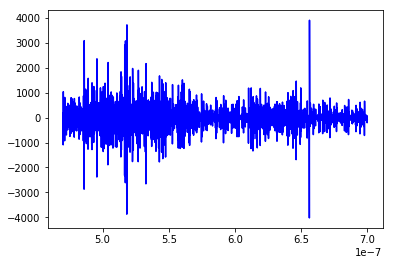

In [74]:
plt.plot(0.5*(wl[1:]+wl[:-1]), B, 'b-')
plt.show()

Numerical artifacts dominate and there is little hope to get a sensible (let alone robust) value using this method.